In [1]:
# Import all necessary modules
import mysql.connector as con
from mysql.connector import Error
import networkx as nx
import networkx.algorithms.community as cm
import matplotlib.pyplot as plt
import datetime as dt
from community import community_louvain
import snap
from random import choice
import numpy as np
import pandas as pd

In [2]:
# Connect to the database built from the dump file
connection = con.connect(host='localhost', database='gitlab_data', user='faraz', password='13771375')
if connection.is_connected():
    db_Info = connection.get_server_info()
    print("Connected to MySQL Server version ", db_Info)
    cursor = connection.cursor()
    cursor.execute("select database();")
    record = cursor.fetchone()
    print("You're connected to database: ", record[0])

Connected to MySQL Server version  5.7.29-0ubuntu0.18.04.1
You're connected to database:  gitlab_data


# Contributions

In [3]:
# user(bigint), project(bigint)
cursor.execute("SELECT * FROM contributions;")
contributions = cursor.fetchall()
print(len(contributions))
for i in range(15):
    print(contributions[i])

90150
(333, 143)
(698, 450)
(733, 526)
(733, 527)
(1357, 1025)
(2546, 2390)
(2752, 2803)
(3031, 2877)
(733, 4304)
(4847, 5366)
(4849, 5369)
(1, 7764)
(14, 7764)
(116, 7764)
(444, 7764)


In [4]:
# Build contributors projection graph
contributorsGraph = nx.Graph()
contributors = set()
for elem in contributions:
    contributors.add(elem[0])
contributors = list(contributors)
contributors.sort()
contributorsGraph.add_nodes_from(contributors)
contProjectSort = sorted(contributions, key=lambda o: o[1])
for i in range(len(contProjectSort)):
    j = i + 1
    while j < len(contProjectSort) and contProjectSort[j][1] == contProjectSort[i][1]:
        if contributorsGraph.has_edge(contProjectSort[i][0], contProjectSort[j][0]):
            contributorsGraph[contProjectSort[i][0]][contProjectSort[j][0]]['weight'] += 1
        else:
            contributorsGraph.add_edge(contProjectSort[i][0], contProjectSort[j][0], weight = 1)
        j += 1

In [5]:
degreeCentrality = nx.degree_centrality(contributorsGraph)
topContributors = [(i, degreeCentrality[i]) for i in degreeCentrality]
topContributors = sorted(topContributors, key = lambda o: o[1], reverse=True)

# Memberships

In [6]:
# user(bigint), project(bigint), from_group(text)
cursor.execute("SELECT * FROM membership;")
memberships = cursor.fetchall()
print(len(memberships))
for i in range(15):
    print(memberships[i])

251277
(1, 7764, None)
(1, 13083, 'gitlab-org')
(1, 13764, 'gitlab-org')
(1, 14022, 'gitlab-org')
(1, 14288, 'gitlab-org')
(1, 14289, 'gitlab-org')
(1, 15195, None)
(1, 16648, 'gitlab-org')
(1, 17744, 'gitlab-com')
(1, 19776, 'gitlab-org')
(1, 20085, 'gitlab-org')
(1, 20086, 'gitlab-org')
(1, 20458, None)
(1, 20699, 'gitlab-org')
(1, 23081, 'gitlab-org')


In [7]:
# Save unweighted members projection graph for visualization
memberProjectGraph = nx.Graph()
members = set()
for elem in memberships:
    members.add(elem[0])
members = list(members)
members.sort()
memberProjectGraph.add_nodes_from(members, bipartite = 0)
maxMember = max(members)
members = set()
for elem in memberships:
    members.add(elem[1] + maxMember)
members = list(members)
members.sort()
memberProjectGraph.add_nodes_from(members, bipartite = 1)
for i in memberships:
    memberProjectGraph.add_edge(i[0], i[1] + maxMember)
nx.write_gexf(memberProjectGraph, "memberProjectBipartite.gexf")

In [8]:
# Calculate average number of contributors of a project
numOfMembers = []
for i in range(len(contProjectSort)):
    j = i + 1
    cnt = 1
    while j < len(contProjectSort) and contProjectSort[j][1] == contProjectSort[i][1]:
        cnt += 1
        j += 1
    numOfMembers.append(cnt)
sum(numOfMembers) / len(numOfMembers)

9.581209095951193

In [9]:
# Build members projection graph
membersGraph = nx.Graph()
members = set()
for elem in memberships:
    members.add(elem[0])
members = list(members)
members.sort()
membersGraph.add_nodes_from(members)
membProjectSort = sorted(memberships, key=lambda o: o[1])
for i in range(len(membProjectSort)):
    j = i + 1
    while j < len(membProjectSort) and membProjectSort[j][1] == membProjectSort[i][1]:
        if membersGraph.has_edge(membProjectSort[i][0], membProjectSort[j][0]):
            membersGraph[membProjectSort[i][0]][membProjectSort[j][0]]['weight'] += 1
        else:
            membersGraph.add_edge(membProjectSort[i][0], membProjectSort[j][0], weight = 1)
        j += 1

In [10]:
degreeCentrality = nx.degree_centrality(membersGraph)
topMembers = [(i, degreeCentrality[i]) for i in degreeCentrality]
topMembers = sorted(topMembers, key = lambda o: o[1], reverse=True)

In [11]:
# Calculate average number of members of a project
numOfMembers = []
for i in range(len(membProjectSort)):
    j = i + 1
    cnt = 1
    while j < len(membProjectSort) and membProjectSort[j][1] == membProjectSort[i][1]:
        cnt += 1
        j += 1
    numOfMembers.append(cnt)
sum(numOfMembers) / len(numOfMembers)

59.231672616276065

# Projects

In [12]:
# id(bigint), path(text), owner_path(text), display_name(text), description(text), avatar(text), stars(int),
# forks(int), owned_by_user(tinyint), commit_count(bigint), storage_size(bigint), repository_size(bigint),
# lfs_objects_size(bigint), archived(tinyint), issues_enabled(tinyint), merge_requests_enabled(tinyint),
# wiki_enabled(tinyint), jobs_enabled(tinyint), snippets_enabled(tinyint), ci_config_path(text),
# created_at(datetime), last_activity(datetime), members_processed(tinybit)
cursor.execute("SELECT * FROM projects;")
projects = cursor.fetchall()
print(len(projects))
for i in range(5):
    print(projects[i], end = '\n\n')
len(projects)

667686
(143, 'teardownwalls', 'leberwurscht', 'TearDownWalls', None, None, 1, 3, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, None, datetime.datetime(2012, 10, 15, 17, 26, 53), datetime.datetime(2013, 10, 3, 8, 8, 46), 1)

(450, 'leiningen', 'technomancy', 'Leiningen', '', None, 1, 0, 1, 4542, 6249512, 6249512, 0, 0, 1, 1, 0, 1, 0, None, datetime.datetime(2012, 12, 12, 21, 30, 14), datetime.datetime(2018, 8, 1, 16, 31, 24), 1)

(526, 'heroes-of-wesnoth', 'jonan', 'Heroes of Wesnoth', None, None, 0, 4, 1, 0, 20143145, 20143145, 0, 0, 1, 1, 1, 1, 0, None, datetime.datetime(2012, 12, 18, 17, 25, 39), datetime.datetime(2015, 4, 9, 14, 43, 49), 1)

(527, 'k', 'jonan', 'K', None, None, 0, 0, 1, 0, 482345, 482345, 0, 0, 1, 1, 1, 0, 0, None, datetime.datetime(2012, 12, 18, 17, 33, 3), datetime.datetime(2014, 10, 11, 22, 29, 4), 1)

(1025, 'hcs_utils', 'hcs', 'hcs_utils', '', None, 0, 0, 1, 144, 671089, 671089, 0, 0, 1, 1, 1, 1, 0, None, datetime.datetime(2013, 1, 6, 20, 35, 42), datetime.datetime(2015, 9,

667686

2012-10-15 17:26:53


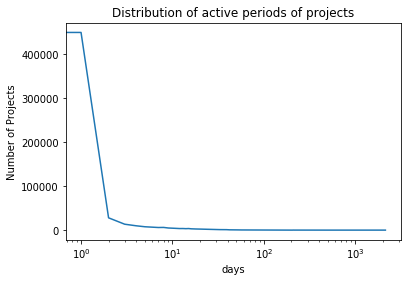

In [39]:
# Plot the distribution of active period for a project
activePeriod = [(i[20], i[21]) for i in projects]
print(activePeriod[0][0])
activeLength = []
for i in activePeriod:
    days = (i[1].year - i[0].year)*365 + (i[1].month - i[0].month)*12 + (i[1].day - i[0].day)
    if days >= 0:
        activeLength.append(days)
    else:
        activeLength.append(0)
days = [0 for i in range(len(activeLength))]
for i in range(len(activeLength)):
    days[i] += 1
DaysNumber = [activeLength.count(0)] + [activeLength.count(i) for i in range(max(activeLength))]
# plt.hist(activeLength)
plt.plot(DaysNumber)
plt.title("Distribution of active periods of projects")
plt.xlabel("days")
# plt.yscale('log')
plt.xscale('log')
# plt.xlim(())
plt.ylabel('Number of Projects')
# plt.grid(True)
plt.show()

In [14]:
# Calculate average contribution rate
membs = sorted(memberships, key = lambda x: x[1])
conts = sorted(contributions, key = lambda x: x[1])
i, j = 0, 0
results = []
while j < len(conts) and i < len(membs):
    jcnt = 0
    icnt = 0
    if membs[i][1] == conts[j][1]:
        const = membs[i][1]
        jj = j + 1
        jcnt = 1
        while jj < len(conts) and conts[jj][1] == const:
            if (conts[jj][0], conts[jj][1]) in membs:
                jcnt += 1
            jj += 1
        j = jj
        ii = i + 1
        icnt = 1
        while ii < len(membs) and membs[ii][1] == const:
            icnt += 1
            ii += 1
        i = ii
#         if icnt > 1:
        results.append(jcnt/icnt)
    elif i < j:
        i += 1
    else:
        j += 1
results
sum(results) / len(results)

0.8250250892611043

# Users

In [15]:
# id(bigint), name(text), username(text), avatar(text), contributions_processed(tinyint)
cursor.execute("SELECT * FROM users;")
users = cursor.fetchall()
print(len(users))
for i in range(5):
    print(users[i], end = '\n\n')

30020
(1, 'Sid Sijbrandij', 'sytses', 'https://secure.gravatar.com/avatar/78b060780d36f51a6763ac9831a4f022?s=80&d=identicon', 1)

(3, 'Travis B. Hartwell', 'travisbhartwell', 'https://secure.gravatar.com/avatar/285ee64568dfd7f3476eb7b6302372b9?s=80&d=identicon', 1)

(14, 'Karen Sijbrandij', 'karen', 'https://secure.gravatar.com/avatar/8b82bce21ec5797488e720b8ed601159?s=80&d=identicon', 1)

(24, 'Philip', 'philip', 'https://secure.gravatar.com/avatar/ad2511e99e9a358c81f7b9530865ef86?s=80&d=identicon', 1)

(29, 'Idlecool', 'idlecool', 'https://secure.gravatar.com/avatar/2d67341a96eb446ce24987a539687f6e?s=80&d=identicon', 1)



In [17]:
# Recognize top members for testing graph building
nominees = [member[0] for member in topMembers[:10]]
for j in range(len(nominees)):
    for i in users:
        if i[0] == nominees[j]:
            print(i[2])
            break

sytses
axil
dblessing
JobV
twk3
marin
balasankarc
tmaczukin
dzaporozhets
Haydn


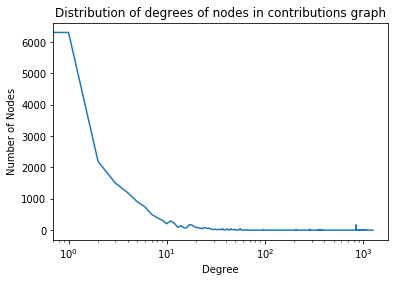

In [38]:
# Evaluate average degree, distribution of nodal degrees, number of connected components,
# giant connected component size, distribution of size of communities in contributions graph

# nx.average_degree_connectivity(contributorsGraph) # Worked => A dictionary
# degreeDic = dict(contributorsGraph.degree())
# sumDegree = 0
# for i in degreeDic:
#     sumDegree += degreeDic[i]
# sumDegree / len(degreeDic)
#
degrees = [contributorsGraph.degree(n) for n in contributorsGraph.nodes()]
contsDegreesNumber = [degrees.count(0)] + [degrees.count(i-1) for i in range(1, max(degrees)+1)]
# plt.hist(degrees)
plt.plot(contsDegreesNumber)
plt.title('Distribution of degrees of nodes in contributions graph')
# plt.yscale('log')
plt.xscale('log')
plt.xlabel('Degree')
plt.ylabel('Number of Nodes')
plt.show() # Worked
#
# connectedComponents = []
# for i in nx.connected_components(contributorsGraph):
#     connectedComponents.append(contributorsGraph.subgraph(i))
# len(connectedComponents) # Worked
#
# hubs, _ = nx.hits(contributorsGraph) # Worked
# hubsList = [(i, hubs[i]) for i in hubs if hubs[i] != 0]
# hubsList1 = [(i, hubs[i]) for i in hubs if hubs[i] == 0]
# hubsSorted = sorted(hubsList, key = lambda o: o[1], reverse=True)
# hubsSorted
# len(hubsList1)
#
# giantConnectedComponent = max(nx.connected_components(contributorsGraph), key=len) # Worked
# len(giantConnectedComponent)
#
# partition = community_louvain.best_partition(contributorsGraph) # Worked
# communities = set()
# for i in partition:
#     communities.add(partition[i])
# max(communities)

# parList = [(i, partition[i]) for i in partition]
# parListSorted = sorted(parList, key = lambda o: o[1])
# numOfCommunityMembers = []
# for i in range(len(parListSorted)):
#     j = i + 1
#     cnt = 1
#     while j < len(parListSorted) and parListSorted[j][1] == parListSorted[i][1]:
#         cnt += 1
#         j += 1
#     numOfCommunityMembers.append(cnt)
# communityNumber = [numOfCommunityMembers.count(1)] + [numOfCommunityMembers.count(i) for i in range(1, max(numOfCommunityMembers)+1)]
# plt.hist(numOfCommunityMembers)
# plt.plot(communityNumber)
# plt.title('Distribution of sizes of communities in contributions graph')
# plt.yscale('log')
# plt.xscale('log')
# plt.xlabel('Size')
# plt.ylabel('Number of Communities')
# plt.show()

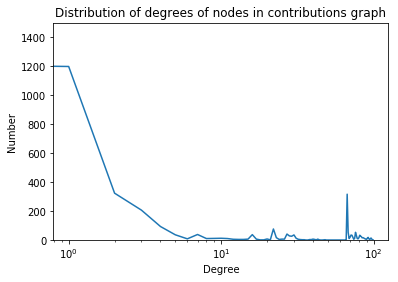

In [35]:
# Plot distribution of nodal degrees
degrees = [contributorsGraph.degree(n) for n in contributorsGraph.nodes()]
degreeX = [i for i in range(max(degrees) + 1)]
degreeY = [degrees.count(i) for i in degreeX]
numOfGroups = 100
Xgroup = [0 for i in range(numOfGroups)]
maxDegree = max(degrees)
for i in degrees:
    Xgroup[int(i*numOfGroups/(maxDegree + 1))] += 1
plt.plot(Xgroup)
plt.title('Distribution of degrees of nodes in contributions graph')
plt.yscale('linear')
plt.ylim(0, 1500)
plt.xscale('log')
plt.xlabel('Degree')
plt.ylabel('Number')
plt.show()

In [38]:
# Calculate effective and full diameter in contributors graph
unweightedSnapContributorsGraph = snap.TUNGraph.New()
contributorsGraph.edges()
for i in contributorsGraph.nodes():
    unweightedSnapContributorsGraph.AddNode(i)
for i in contributorsGraph.edges():
    unweightedSnapContributorsGraph.AddEdge(i[0], i[1])
diameter = 0
print(snap.GetBfsEffDiam(unweightedSnapContributorsGraph, 1))
print(snap.GetBfsFullDiam(unweightedSnapContributorsGraph, 1))

print(snap.GetBfsEffDiam(unweightedSnapContributorsGraph, 10))
print(snap.GetBfsFullDiam(unweightedSnapContributorsGraph, 10))

print(snap.GetBfsEffDiam(unweightedSnapContributorsGraph, 100))
print(snap.GetBfsFullDiam(unweightedSnapContributorsGraph, 100))

print(snap.GetBfsEffDiam(unweightedSnapContributorsGraph, 1000))
print(snap.GetBfsFullDiam(unweightedSnapContributorsGraph, 1000))

0.8923076923076922
3
4.580297397769518
10
4.193377143443886
12
4.485911224737179
17


In [40]:
# Calculate clustering coefficients in contributors graph
print(snap.GetClustCf(unweightedSnapContributorsGraph, 1))
print(snap.GetClustCf(unweightedSnapContributorsGraph, 10))
print(snap.GetClustCf(unweightedSnapContributorsGraph, 100))
print(snap.GetClustCf(unweightedSnapContributorsGraph, 1000))
print(snap.GetClustCf(unweightedSnapContributorsGraph, 10000))

0.9673465399059067
0.4967346539905907
0.4554091781062845
0.47811882267454275
0.46807052661512744


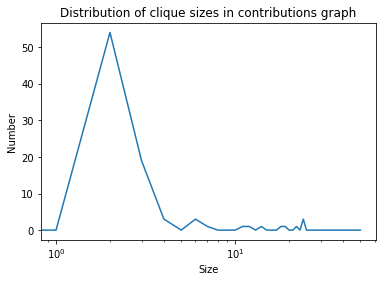

In [32]:
# Plot the distribution of size of cliques in contributors graph

# taken_nodes = set()
# while len(taken_nodes) < 1000:
#     node = choice(list(contributorsGraph.nodes()))
#     if node not in taken_nodes:
#         taken_nodes.add(node)
# subgraph = contributorsGraph.subgraph(taken_nodes)
# cliques = []
# for i in nx.algorithms.clique.find_cliques(subgraph):
#     if len(subgraph.subgraph(i)) != 1:
#         cliques.append(subgraph.subgraph(i))
# print(len(cliques))
# cliqueSizes = [len(i) for i in cliques]
# cliqueSizesNumber = [cliqueSizes.count(i) for i in range(max(cliqueSizes))]
# communityNumber = [cliqueSizesNumber.count(0)] + [cliqueSizesNumber.count(i-1) for i in range(1, max(cliqueSizesNumber)+1)]
plt.plot(cliqueSizesNumber)
# plt.hist(cliqueSizes)
plt.title('Distribution of clique sizes in contributions graph')
# plt.yscale('log')
plt.xscale('log')
plt.xlabel('Size')
plt.ylabel('Number')
plt.show()

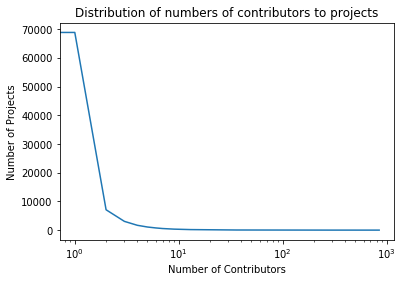

In [31]:
# Plot the distribution of number of contributors to a project

numOfContributors = []
for i in range(len(contProjectSort)):
    j = i + 1
    cnt = 0
    while j < len(contProjectSort) and contProjectSort[j][1] == contProjectSort[i][1]:
        cnt += 1
        j += 1
    numOfContributors.append(cnt)
contributorsNumber = [numOfContributors.count(0)] + [numOfContributors.count(i-1) for i in range(1, max(numOfContributors))]
# plt.hist(numOfContributors, color = 'lightsalmon')
plt.plot(contributorsNumber)
plt.title('Distribution of numbers of contributors to projects')
# plt.yscale('log')
plt.xscale('log')
plt.xlabel('Number of Contributors')
plt.ylabel('Number of Projects')
# plt.grid(True)
plt.show()

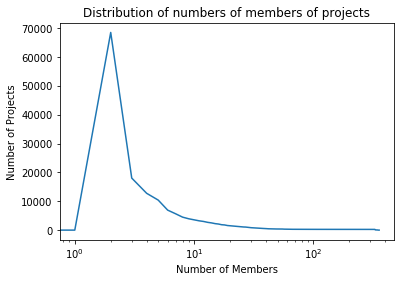

In [30]:
# Plot the distribution of number of members of a project

numOfMembers = []
for i in range(len(membProjectSort)):
    j = i + 1
    cnt = 1
    while j < len(membProjectSort) and membProjectSort[j][1] == membProjectSort[i][1]:
        cnt += 1
        j += 1
    numOfMembers.append(cnt)
membersNumber = [numOfMembers.count(0)] + [numOfMembers.count(i-1) for i in range(1, max(numOfMembers))]
# plt.hist(numOfMembers, color = 'limegreen')
plt.plot(membersNumber)
# plt.yscale('log')
plt.xscale('log')
plt.xlabel('Number of Members')
plt.ylabel('Number of Projects')
plt.title('Distribution of numbers of members of projects')
# plt.grid(True)
plt.show()

In [25]:
# Evaluate average degree, distribution of nodal degrees, number of connected components,
# giant connected component size, distribution of size of communities in members graph

len(membersGraph.nodes())

# degreeDic = membersGraph.degree()
# sumDegree = 0
# for i in degreeDic:
#     sumDegree += degreeDic[i]
# sumDegree / len(degreeDic)
#
# degrees = [membersGraph.degree(n) for n in membersGraph.nodes()]
# membDegreesNumber = [degrees.count(0)] + [degrees.count(i-1) for i in range(1, max(degrees)+1)]
# plt.hist(degrees)
# plt.plot(membDegreesNumber)
# plt.title('Distribution of degrees of nodes in members graph')
# plt.yscale('log')
# plt.xscale('log')
# plt.xlabel('Degree')
# plt.ylabel('Number of Nodes')
# plt.show() # Worked
#
# connectedComponents = []
# for i in nx.connected_components(membersGraph):
#     connectedComponents.append(membersGraph.subgraph(i))
# len(connectedComponents) # Worked
#
# hubs, _ = nx.hits(membersGraph) # Worked
# hubsList = [(i, hubs[i]) for i in hubs if hubs[i] != 0]
# hubsList1 = [(i, hubs[i]) for i in hubs if hubs[i] == 0]
# hubsSorted = sorted(hubsList, key = lambda o: o[1], reverse=True)
# hubsSorted
# len(hubsList1)
#
# giantConnectedComponent = max(nx.connected_components(membersGraph), key=len) # Worked
# len(giantConnectedComponent)
# avgColabs = [len(i) for i in nx.connected_components(membersGraph)]
# avgColabsNum = 0
# for i in avgColabs:
#     avgColabsNum += i * (i-1)
# avgColabsNum / sum(avgColabs)

membersComponents = [membersGraph.subgraph(c) for c in nx.connected_components(membersGraph)]
membersComponents.sort(key=len)
count = 0
for i in membersComponents:
    if len(i) == 1:
        count += 1
print(count / sum([len(i) for i in membersComponents]))
print(count)
sum([len(i) for i in membersComponents])
# print(len(giantConnectedComponent) / sum(membersComponents))
#
# partition = community_louvain.best_partition(membersGraph) # Worked
# communities = set()
# for i in partition:
#     communities.add(partition[i])
# max(communities)

# parList = [(i, partition[i]) for i in partition]
# parListSorted = sorted(parList, key = lambda o: o[1])
# numOfCommunityMembers = []
# for i in range(len(parListSorted)):
#     j = i + 1
#     cnt = 0
#     while j < len(parListSorted) and parListSorted[j][1] == parListSorted[i][1]:
#         cnt += 1
#         j += 1
#     numOfCommunityMembers.append(cnt)
# communityNumber = [numOfCommunityMembers.count(0)] + [numOfCommunityMembers.count(i-1) for i in range(1, max(numOfCommunityMembers)+1)]
# plt.hist(numOfCommunityMembers)
# plt.plot(communityNumber)
# plt.title('Distribution of sizes of communities in members graph')
# plt.yscale('log')
# plt.xscale('log')
# plt.xlabel('Size')
# plt.ylabel('Number of Communities')
# plt.show()

0.07405063291139241
2223


30020

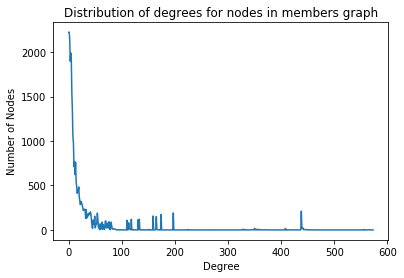

In [25]:
# Plot the distribution of nodal degrees in members graph
plt.plot(membDegreesNumber)
plt.title('Distribution of degrees for nodes in members graph')
# plt.yscale('log')
# plt.xscale('log')
plt.xlabel('Degree')
plt.ylabel('Number of Nodes')
plt.show()

In [27]:
# Calculate effective and full diameter in members graph
unweightedSnapMembersGraph = snap.TUNGraph.New()
membersGraph.edges()
for i in membersGraph.nodes():
    unweightedSnapMembersGraph.AddNode(i)
for i in membersGraph.edges():
    unweightedSnapMembersGraph.AddEdge(i[0], i[1])
diameter = 0
print(snap.GetBfsEffDiam(unweightedSnapMembersGraph, 1))
print(snap.GetBfsFullDiam(unweightedSnapMembersGraph, 1))

print(snap.GetBfsEffDiam(unweightedSnapMembersGraph, 10))
print(snap.GetBfsFullDiam(unweightedSnapMembersGraph, 10))

print(snap.GetBfsEffDiam(unweightedSnapMembersGraph, 100))
print(snap.GetBfsFullDiam(unweightedSnapMembersGraph, 100))

print(snap.GetBfsEffDiam(unweightedSnapMembersGraph, 1000))
print(snap.GetBfsFullDiam(unweightedSnapMembersGraph, 1000))

0.8956521739130435
1
9.437861635220127
16
9.913540663272327
18
10.2536
19


In [28]:
# Calculate clustering coefficients in members graph
print(snap.GetClustCf(unweightedSnapMembersGraph, 1))
print(snap.GetClustCf(unweightedSnapMembersGraph, 10))
print(snap.GetClustCf(unweightedSnapMembersGraph, 100))
print(snap.GetClustCf(unweightedSnapMembersGraph, 1000))
print(snap.GetClustCf(unweightedSnapMembersGraph, 10000))

1.0
1.0
0.9037863809819968
0.8927158499228085
0.8886278372027074


4272


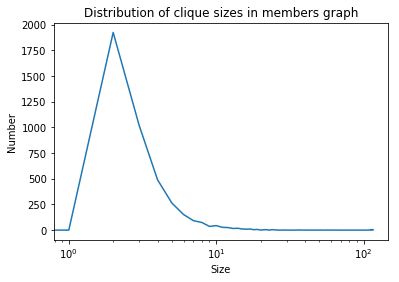

In [19]:
# Plot the distribution of size of cliques in members graph
taken_nodes = set()
while len(taken_nodes) < 10000:
    node = choice(list(membersGraph.nodes()))
    if node not in taken_nodes:
        taken_nodes.add(node)
subgraph = membersGraph.subgraph(taken_nodes)
cliques = []
for i in nx.algorithms.clique.find_cliques(subgraph):
#     if len(subgraph.subgraph(i)) != 1:
    cliques.append(subgraph.subgraph(i))
print(len(cliques))
cliqueSizes = [len(i) for i in cliques]
cliquesNumber = [cliqueSizes.count(0)] + [cliqueSizes.count(i-1) for i in range(1, max(cliqueSizes)+1)]
# plt.hist(cliqueSizes)
plt.plot(cliquesNumber)
# plt.yscale('log')
plt.xscale('log')
plt.xlabel('Size')
plt.ylabel('Number')
plt.title('Distribution of clique sizes in members graph')
plt.show()

In [30]:
# Calculate degree assortativity for members and contributors graph
print(nx.degree_assortativity_coefficient(membersGraph))
print(nx.degree_assortativity_coefficient(contributorsGraph))

0.512468831833
0.813531181331


In [32]:
# Close database connection
if (connection.is_connected()):
    cursor.close()
    connection.close()
    print("MySQL connection is closed")

MySQL connection is closed
